In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
df = pd.read_excel('online_retail_adj.xlsx')

In [3]:
df.head(20)

,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
5,5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.65,13085,United Kingdom
6,6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.25,13085,United Kingdom
7,7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.95,13085,United Kingdom
8,8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.55,13085,United Kingdom
9,9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.75,13085,United Kingdom


#### Preliminary EDA Goals

Because we're conducting a customer-focused analysis, we'll be using this notebook to 1) engineer features which are commonly used in predictive and descriptive customer analytics and 2) explore those features through an RFM lens.

In [4]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
df.sort_values(by='Customer ID')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
521341,537434,21391,FRENCH LAVENDER SCENT HEART,2,2010-12-06 16:57:00,4.21,1,United Kingdom
521702,537434,22862,LOVE HEART NAPKIN BOX,3,2010-12-06 16:57:00,8.47,1,United Kingdom
521703,537434,22865,HAND WARMER OWL DESIGN,9,2010-12-06 16:57:00,2.10,1,United Kingdom
521704,537434,22866,HAND WARMER SCOTTY DOG DESIGN,14,2010-12-06 16:57:00,2.10,1,United Kingdom
521705,537434,22867,HAND WARMER BIRD DESIGN,4,2010-12-06 16:57:00,4.21,1,United Kingdom
...,...,...,...,...,...,...,...,...
154285,508581,84327A,PINK JUMPER LARRY THE LAMB,6,2010-05-17 11:55:00,2.10,18287,United Kingdom
154284,508581,21841,BABY MOUSE RED GINGHAM DRESS,3,2010-05-17 11:55:00,4.25,18287,United Kingdom
154283,508581,84581,DOG TOY WITH PINK CROCHET SKIRT,4,2010-05-17 11:55:00,3.75,18287,United Kingdom
383789,534346,C2,CARRIAGE,1,2010-11-22 11:51:00,50.00,18287,United Kingdom


In [6]:
# At this point we want to start generating features that will be used in the customer analysis. We'll start by generating total transaction value per invoice.

df['Item Total'] = df['Quantity'] * df['Price']

In [7]:
dotcom = df[df['Description'] == 'Dotcom sales']

In [8]:
df = df.drop(dotcom.index)

In [9]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Item Total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
525454,538154,85099B,JUMBO BAG RED RETROSPOT,1,2010-12-09 16:35:00,4.21,668,United Kingdom,4.21
525455,538154,DOT,DOTCOM POSTAGE,1,2010-12-09 16:35:00,85.79,668,United Kingdom,85.79
525456,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,3134,United Kingdom,-0.00
525457,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,4914,United Kingdom,-0.00


In [13]:
amznfee = df[df['StockCode'] == 'AMAZONFEE']
amznfee

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Item Total
504294,C531400,AMAZONFEE,AMAZON FEE,-1,2010-11-08 10:08:00,6706.71,4897,United Kingdom,-6706.71
504304,531411,AMAZONFEE,AMAZON FEE,1,2010-11-08 10:11:00,6706.71,4165,United Kingdom,6706.71
522005,C537600,AMAZONFEE,AMAZON FEE,-1,2010-12-07 12:41:00,1.00,3695,United Kingdom,-1.00
522012,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,3612,United Kingdom,-13541.33
522013,537632,AMAZONFEE,AMAZON FEE,1,2010-12-07 15:08:00,13541.33,3217,United Kingdom,13541.33
523205,C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:34:00,13474.79,2761,United Kingdom,-13474.79
523206,C537647,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:41:00,5519.25,3991,United Kingdom,-5519.25
523207,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,3756,United Kingdom,-13541.33
523208,C537652,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:51:00,6706.71,2758,United Kingdom,-6706.71


Based on the above, we are going to remove Amazon Fees from the dataset.

In [14]:
df= df.drop(amznfee.index)

In [15]:
df[df['Description'] == 'Manual'].describe()

,Quantity,Price,Customer ID,Item Total
count,854.000000,854.000000,854.000000,854.000000
mean,1.694379,628.753150,12256.645199,-16.521815
std,19.492363,1940.337681,5513.895473,2039.783225
min,-408.000000,0.000000,299.000000,-25111.090000
25%,-1.000000,1.450000,12354.500000,-45.442500
50%,1.000000,15.475000,14515.000000,2.725000
75%,1.000000,397.587500,15939.000000,20.187500
max,144.000000,25111.090000,18257.000000,25111.090000


Doesn't look like there's much of a pattern to the Manual transactions. 

During our EDA we also found a few indicators of non-customer transactions - we'll remove those below.

In [16]:
dotcom = df[df['Description'] == 'Dotcom sales']

In [17]:
df = df.drop(dotcom.index)

In [18]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Item Total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.40
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.80
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.00
...,...,...,...,...,...,...,...,...,...
525454,538154,85099B,JUMBO BAG RED RETROSPOT,1,2010-12-09 16:35:00,4.21,668,United Kingdom,4.21
525455,538154,DOT,DOTCOM POSTAGE,1,2010-12-09 16:35:00,85.79,668,United Kingdom,85.79
525456,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,3134,United Kingdom,-0.00
525457,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,4914,United Kingdom,-0.00


{'whiskers': [<matplotlib.lines.Line2D at 0x25357a57ac8>,
 'caps': [<matplotlib.lines.Line2D at 0x25357a57988>,
 'boxes': [<matplotlib.lines.Line2D at 0x25357a57488>],
 'medians': [<matplotlib.lines.Line2D at 0x25357a5d4c8>],
 'fliers': [<matplotlib.lines.Line2D at 0x25357a5da08>],
 'means': []}

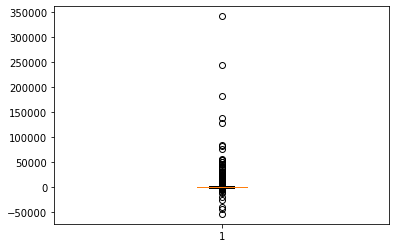

In [19]:
cust_transactions = pd.pivot_table(df,index=['Customer ID'],values='Item Total',aggfunc=np.sum)
plt.boxplot(cust_transactions['Item Total'])

This boxplot is interesting. There are some clear outliers - 5 customers each representing above 125k in sales over the period - but a few who represent negative sales. We'll have to further explore the negative-value customers.

In [22]:
neg_customers = cust_transactions[cust_transactions['Item Total'] < 0].index.values
neg = df[df['Customer ID'].isin(neg_customers)]
neg.sort_values('Customer ID').tail()
neg.sort_values('InvoiceDate')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Item Total
174,489448,20827,GOLD APERITIF GLASS,48,2009-12-01 10:18:00,2.12,15413,United Kingdom,101.76
175,489448,20825,GOLD WINE GLASS,48,2009-12-01 10:18:00,3.39,15413,United Kingdom,162.72
176,489448,20823,GOLD WINE GOBLET,48,2009-12-01 10:18:00,4.25,15413,United Kingdom,204.00
177,489448,20826,SILVER APERITIF GLASS,48,2009-12-01 10:18:00,2.12,15413,United Kingdom,101.76
208,C489459,90082D,DIAMANTE BOW BROOCH BLACK COLOUR,-2,2009-12-01 10:44:00,6.35,17592,United Kingdom,-12.70
...,...,...,...,...,...,...,...,...,...
522004,C537581,S,SAMPLES,-1,2010-12-07 12:03:00,52.00,1285,United Kingdom,-52.00
522006,C537610,M,Manual,-1,2010-12-07 13:23:00,631.31,5080,United Kingdom,-631.31
522007,C537613,M,Manual,-1,2010-12-07 13:28:00,313.78,3170,United Kingdom,-313.78
417153,538120,22198,LARGE POPCORN HOLDER,50,2010-12-09 15:35:00,1.45,17017,United Kingdom,72.50


Through this exploration we've learned a few things.

* Customers with a negative value have invoice dates ranging from the beginning to the end of the dataset.
* There are a few non-customer transactions included in here - like Amazon Fee and "Manual."

In [27]:
cust_transactions = cust_transactions.sort_values('Item Total')

In [38]:
cust_transactions['M'] = pd.qcut(cust_transactions['Item Total'],5,labels=[1,2,3,4,5])

In [39]:
cust_transactions.M.value_counts()

1    3583
5    1920
4    1920
3    1920
2     258
Name: M, dtype: int64

In [41]:
inv_per_cust =  pd.pivot_table(df,index=['Customer ID'],values='Invoice',aggfunc=lambda x: len(x.unique()))

In [43]:
inv_per_cust.sort_values('Invoice')

,Invoice
Customer ID,
1,1
4341,1
4340,1
4339,1
4338,1
...,...
14156,138
15311,158
17850,158


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000025351774DC8>]],
      dtype=object)

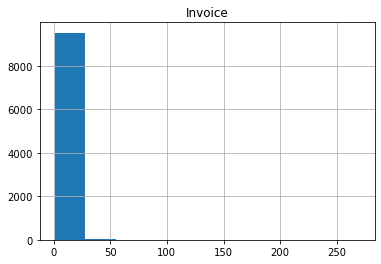

In [46]:
inv_per_cust.hist()

In [51]:
inv_per_cust['Invoice'].value_counts().head(50)

1      6485
2       773
3       486
4       383
5       256
6       218
8       167
7       163
9        87
10       81
12       65
11       59
14       49
13       43
15       41
16       34
18       22
17       21
22       15
21       14
19       13
25       13
24       12
28        8
20        7
23        6
26        5
27        5
35        5
34        5
32        4
42        4
30        4
29        3
51        3
72        2
87        2
49        2
33        2
31        2
158       2
52        2
53        2
63        1
41        1
270       1
126       1
48        1
56        1
64        1
Name: Invoice, dtype: int64

Based on the distribution of invoices per customer - i.e. number of transactions per customer during the 18 month period covered by the dataset - we can't use the built in qcut function. We'll use some artificial frequency boundaries (1, 2-5, 5+) to generate.

In [ ]:
bins = pd.IntervalIndex.from_tuples([(0,1),(2,5),(5,1000)])

In [65]:
helperdict = dict(zip(bins,[1,2,3]))

In [66]:
cust_transactions['F'] = pd.cut(inv_per_cust['Invoice'],bins=bins,labels=[1,2,3]).map(helperdict)

In [67]:
cust_transactions

,Item Total,M,F
Customer ID,,,
3567,-53594.36,1,1
5192,-44031.79,1,1
2287,-38925.87,1,1
17399,-25111.09,1,1
5157,-18910.69,1,1
...,...,...,...
13694,128172.42,5,3
14911,137675.91,5,3
14156,183180.55,5,3


In [87]:
order_timing = pd.pivot_table(df,index=['Customer ID'],values='InvoiceDate',aggfunc=max)

In [88]:
order_timing

,InvoiceDate
Customer ID,
1,2010-12-06 16:57:00
2,2010-12-09 14:09:00
3,2010-12-07 15:28:00
4,2010-12-06 09:58:00
5,2010-12-03 11:36:00
...,...
18283,2010-11-22 15:30:00
18284,2010-10-06 12:31:00
18285,2010-02-17 10:24:00


In [91]:
print(df['InvoiceDate'].min())
print(df['InvoiceDate'].max())

2009-12-01 07:45:00
2010-12-09 20:01:00


In [112]:
last_day = pd.to_datetime(df['InvoiceDate'].max())
first_day = pd.to_datetime(df['InvoiceDate'].min())

In [115]:
days_30 = last_day - timedelta(days=30)
days_30_1 = last_day - timedelta(days=30,seconds=1)
days_90 = last_day - timedelta(days=90)
days_90_1 = last_day - timedelta(days=90,seconds=1)
last_bin = last_day - timedelta(days=90,seconds=1)

In [117]:
bins = pd.IntervalIndex.from_tuples([(first_day,days_90_1),(days_90,days_30_1),(days_30,last_day)])
helperdict2 = dict(zip(bins,[1,2,3]))
cust_transactions['R'] = pd.cut(order_timing['InvoiceDate'],bins=bins,labels=[1,2,3]).map(helperdict2)

In [118]:
cust_transactions

,Item Total,M,F,R
Customer ID,,,,
3567,-53594.36,1,1,1
5192,-44031.79,1,1,1
2287,-38925.87,1,1,2
17399,-25111.09,1,1,1
5157,-18910.69,1,1,1
...,...,...,...,...
13694,128172.42,5,3,3
14911,137675.91,5,3,3
14156,183180.55,5,3,3


Now we have a dataframe that includes four pieces of information:
* Customer ID
* Total monetary value provided by each customer
* M - a ranking of total value by customer (1 = low value, 5 = high value)
* F - a ranking of frequency (1 = 1 transaction during the time period, 2 = 2-4 transactions, 3 = 5+ transactions)

Importantly - these groupings were done by eyeballing and intuition. In the next workbook, we will try using clustering to determine a more refined approach to binning our customers. 